In [1]:
# Import necessary packages
import pandas as pd
import os
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
sns.set(font_scale=1.5)

In [2]:
# Check current working directory.
os.getcwd()

'C:\\Users\\yikun.sun\\Desktop\\Python\\Heart Failure Prediction'

In [3]:
# Import the dataset, name it as data.
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [4]:
# Check the number of rows and columns in the dataset.
# There are only 299 records, 12 features, and 1 target variable.
data.shape

(299, 13)

In [5]:
# Check if there's any missing values in the dataset.
# There isn't any missing values.
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [6]:
# Take a look at statistics summary of the dataset.
# The youngest patient is 40, so all the patients are at least 40 years old.
# There are outliers in: creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine.
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [7]:
data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

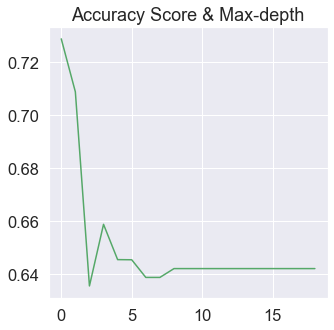

In [8]:
# Let's firstly build a baseline Decision Tree model before feature engineering.
x = data.copy()
y = x.pop('DEATH_EVENT')

# Build an empty list to store accuracy scores of the model while tuning max_depth.
def cro_val(x, y):
    bta = []
    for i in range(1, 20):
        decision_tree = DecisionTreeClassifier(random_state = 0, max_depth = i)
        bta.append(cross_val_score(decision_tree, x, y, cv = 5, scoring='accuracy').mean())
    return bta
    
# Visualize accuracy scores to see which value of max_depth brings the highest accuracy.
f, ax = plt.subplots(figsize=(5,5))
plt.plot(cro_val(x, y), 'g')
plt.title('Accuracy Score & Max-depth')
plt.show()

In [9]:
# Set max_depth to 1 for highest accuracy.
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=1)
basetreea = cross_val_score(decision_tree, x, y, cv=5, scoring='accuracy').mean()
print('Baseline Decision Tree\'s accuracy is {:.2%}'.
      format(basetreea))

Baseline Decision Tree's accuracy is 72.89%


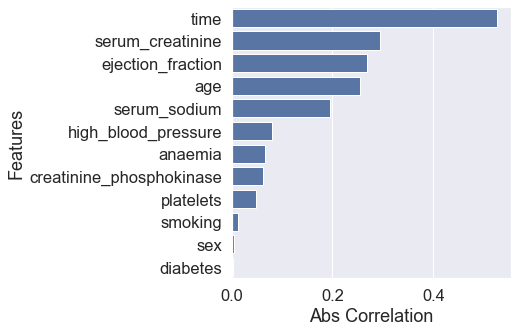

In [10]:
# Build a DataFrame called cor to store correlation between all the features and DEATH_EVENT.
cor = pd.DataFrame(data.corr()['DEATH_EVENT']).reset_index()
cor.drop(12, inplace=True)
cor.rename(columns={'index':'Features', 'DEATH_EVENT':'Abs Correlation'}, inplace=True)
cor['Abs Correlation'] = abs(cor['Abs Correlation'])
cor.sort_values(by='Abs Correlation', ascending=False, inplace=True)

# Visualize correlations to see which features have more influence over DEATH_EVENT.
# It seems time, serum_creatinine, ejection_fraction, age, and serum_sodium have higher influence on survival of patients.
# So we will use these five features to predict survival.
f, ax = plt.subplots(figsize=(5,5))
sns.barplot(x=cor['Abs Correlation'], y=cor.Features, color = 'b')
plt.show()

five = ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium']

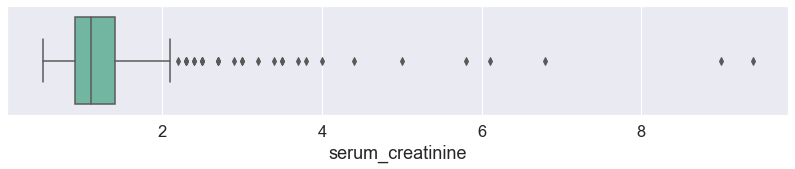

<Figure size 432x288 with 0 Axes>

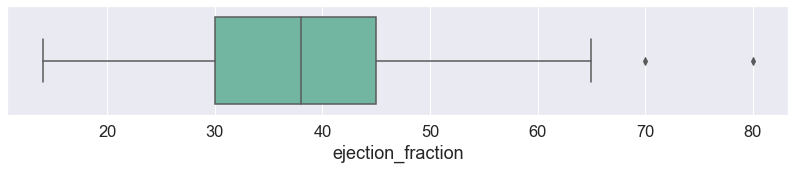

In [11]:
# Because serum_creatinine and ejection_fraction have outliers, we need to replace the outliers first.
# Let's generate boxplots for both serum_creatinine and ejection_fraction.
f, ax = plt.subplots(figsize=(14,2))
sns.boxplot(x=data.serum_creatinine, palette='Set2')

plt.figure()
f, ax = plt.subplots(figsize=(14,2))
sns.boxplot(x=data.ejection_fraction, palette='Set2')
plt.show()

In [12]:
# Since there are only 2 outliers in ejection_fraction, which represent 0.6% of our sample, we can remove them first.
data.drop(data[data.ejection_fraction>=70].index, inplace=True)

In [13]:
# Define a function first to capture outliers in a feature.
def outliers(x):
    outliers=[]
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    upper = q3+1.5*iqr
    lower = q1-1.5*iqr
    for i in x:
        if i > upper:
            outliers.append(i)
        elif i < lower:
            outliers.append(i)
    return outliers

In [14]:
# Less than 10% of data in serum_creatinine are outliers.
len(outliers(data.serum_creatinine))/len(data.serum_creatinine)

# Since serum_creatinine doesn't have a strong correlation with other features, 
# the best approach would be replace outliers with mean value.
data.serum_creatinine = data.serum_creatinine.replace(outliers(data.serum_creatinine), 
                                                     np.nan).fillna(np.mean(data.serum_creatinine))

In [15]:
# After replacing outliers in features, we start training and evaluating our models.
# Split the dataset into training and testing sets.
features = ['time', 'serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium']
x = data[features]
y = data['DEATH_EVENT']
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

In [16]:
# The features have very different scales.
# Values of time can be as large as hundreds, while serum_creatinine can be lower than 1.
# We'd better standardize our data to achieve a higher predictive accuracy.
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)

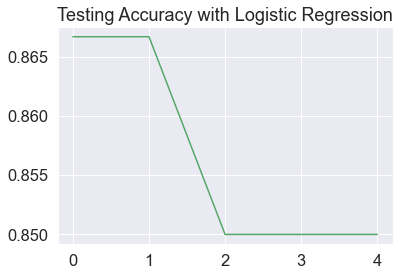

In [17]:
# Let's implement a Logistic Regression model first.
# Use a for loop to find the optimal value of max_iter.
warnings.filterwarnings("ignore")

log_testing_acu = []
for i in range(5):
    log_reg = LogisticRegression(max_iter = i)
    log_reg.fit(train_x, train_y)
    log_testing_acu.append(log_reg.score(test_x, test_y))
    
plt.title('Testing Accuracy with Logistic Regression')
plt.plot(log_testing_acu, 'g')
plt.show()

In [18]:
# When max_iter is set to 0 or 1, accuracy is highest.
log_reg = LogisticRegression(max_iter = 1)
log_reg.fit(train_x, train_y)
log_reg_train_accuracy = round(log_reg.score(train_x, train_y)*100, 2)
log_reg_test_accuracy = round(log_reg.score(test_x, test_y)*100, 2)
print("Accuracy with Logistic Regression on training data is {}".format(log_reg_train_accuracy))
print("Accuracy with Logistic Regression on testing data is {}".format(log_reg_test_accuracy))

Accuracy with Logistic Regression on training data is 83.54
Accuracy with Logistic Regression on testing data is 86.67


In [19]:
# Based on results of the model, serum_creatinine and age are positively correlated with DEATH_EVENT.
# Meaning patients with a higher level of serum_creatinine and patients at an older age are more likely to pass away.
# When the follow-up period increases, patients are more likely to survive. 
# This is a very interesting finding as to why the follow-up period would affect a patient's likelihood to survival?
# Maybe when doctors feel a patient is not in a serious condition, they won't follow up to check on the patient until much later.
# Patients with a higher level of serum_sodium and those with a higher level of ejection_fraction are more likely to survive.
log_results = pd.DataFrame(log_reg.coef_[0], features, columns=['Coefficient']).reset_index()
log_results = log_results.rename(columns={'index': 'Feature'}).sort_values(by='Coefficient', ascending=False)
log_results

,Feature,Coefficient
1,serum_creatinine,0.455215
3,age,0.269435
4,serum_sodium,-0.259712
2,ejection_fraction,-0.385225
0,time,-0.563985


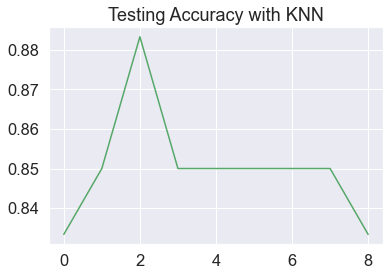

In [20]:
# Next model to implement is KNN. 
# Use a for loop to find the optimal value of n_neighbors.
knn_testing_acu = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_x, train_y)
    knn_testing_acu.append(knn.score(test_x, test_y))

plt.title('Testing Accuracy with KNN')
plt.plot(knn_testing_acu, 'g')
plt.show()

In [21]:
# Setting n_neighbors to 3 brings us the highest accuracy on testing data.
# Accuracy score of KNN is slightly higher than that of Logistic Regression.
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x, train_y)
knn_train_accuracy = round(knn.score(train_x, train_y)*100, 2)
knn_test_accuracy = round(knn.score(test_x, test_y)*100, 2)
print('Accuracy with KNN on training data is {}'.format(knn_train_accuracy))
print('Accuracy with KNN on testing data is {}'.format(knn_test_accuracy))

Accuracy with KNN on training data is 88.61
Accuracy with KNN on testing data is 88.33


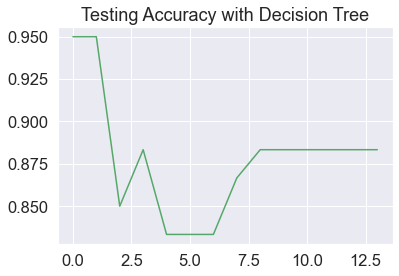

In [22]:
# Decision Tree Classifier model
tree_testing_acu = []
for i in range(1, 15):
    tree = DecisionTreeClassifier(random_state=0, max_depth=i)
    tree.fit(train_x, train_y)
    tree_testing_acu.append(tree.score(test_x, test_y))
    
plt.title('Testing Accuracy with Decision Tree')
plt.plot(tree_testing_acu, 'g')
plt.show()

In [23]:
# Setting max_depth to 1 brings the highest accuracy.
tree = DecisionTreeClassifier(random_state=0, max_depth=1)
tree.fit(train_x, train_y)
tree_train_accuracy = round(tree.score(train_x, train_y)*100, 2)
tree_test_accuracy = round(tree.score(test_x, test_y)*100, 2)
print('Accuracy with Decision Tree on training data is {}'.format(tree_train_accuracy))
print('Accuracy with Decision Tree on testing data is {}'.format(tree_test_accuracy))

Accuracy with Decision Tree on training data is 82.7
Accuracy with Decision Tree on testing data is 95.0


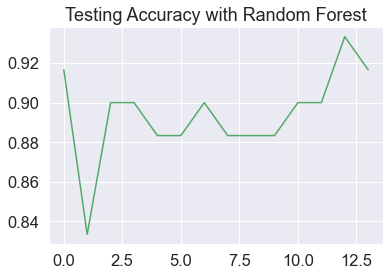

In [24]:
# Random Forest Classifier model
forest_testing_acu = []
for i in range(1, 15):
    random_forest = RandomForestClassifier(random_state=0, n_estimators=i)
    random_forest.fit(train_x, train_y)
    forest_testing_acu.append(random_forest.score(test_x, test_y))
    
plt.title('Testing Accuracy with Random Forest')
plt.plot(forest_testing_acu, 'g')
plt.show()

In [25]:
# Setting n_estimators to 13 brings the highest accuracy.
# Even though the accuracy on testing data is slightly lower than that of Decision Tree, the accuracy on training data is much higher, almost 100%.
random_forest = RandomForestClassifier(random_state=0, n_estimators=13)
random_forest.fit(train_x, train_y)
forest_train_accuracy = round(random_forest.score(train_x, train_y)*100, 2)
forest_test_accuracy = round(random_forest.score(test_x, test_y)*100, 2)
print("Random Forest's accuracy on training data is {}".format(forest_train_accuracy))
print("Random Forest's accuracy on testing data is {}".format(forest_test_accuracy))

Random Forest's accuracy on training data is 98.73
Random Forest's accuracy on testing data is 93.33


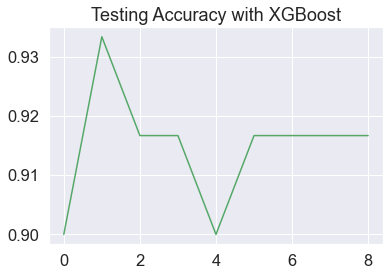

In [26]:
# Last model to implement is XGBoost
xgb_testing_acu = []
for i in range(50, 500, 50):
    xgb_model = XGBClassifier(n_estimators = i, learning_rate = 0.01, eval_metric='logloss')
    xgb_model.fit(train_x, train_y,
                 early_stopping_rounds = 5,
                 eval_set=[(test_x, test_y)],
                 verbose=False)
    xgb_testing_acu.append(xgb_model.score(test_x, test_y))

plt.title('Testing Accuracy with XGBoost')
plt.plot(xgb_testing_acu, 'g')
plt.show()

In [27]:
# Setting n_estimators to 100 gives us the highest accuracy on testing data.
xgb_model = XGBClassifier(n_estimators = 100, learning_rate = 0.01, eval_metric='logloss')
xgb_model.fit(train_x, train_y,
              early_stopping_rounds = 5,
              eval_set=[(test_x, test_y)],
              verbose=False)
xgb_train_accuracy = round(xgb_model.score(train_x, train_y)*100, 2)
xgb_test_accuracy = round(xgb_model.score(test_x, test_y)*100, 2)
print("XGBoost's accuracy on training data is {}".format(xgb_train_accuracy))
print("XGBoost's accuracy on testing data is {}".format(xgb_test_accuracy))

XGBoost's accuracy on training data is 92.83
XGBoost's accuracy on testing data is 93.33


In [28]:
# Build 1 DataFrame to store accuracy of each model on training and testing data.
# Decision Tree has the highest accuracy on testing data of all models, however, the accuracy on training data is the lowest.
# Random Forest performs best given being almost 100% accurate on training data and over 93% on testing data.
accuracy = pd.DataFrame({'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost'],
                         'Training': [log_reg_train_accuracy, knn_train_accuracy, tree_train_accuracy,
                                            forest_train_accuracy, xgb_train_accuracy],
                        'Testing': [log_reg_test_accuracy, knn_test_accuracy, tree_test_accuracy,
                                         forest_test_accuracy, xgb_test_accuracy]}).sort_values(by='Testing', 
                                                                                                ascending=False)
accuracy

,Model,Training,Testing
2,Decision Tree,82.70,95.00
3,Random Forest,98.73,93.33
4,XGBoost,92.83,93.33
1,KNN,88.61,88.33
0,Logistic Regression,83.54,86.67


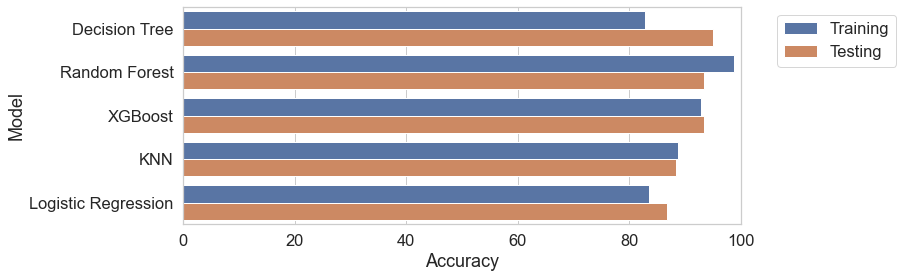

In [29]:
# Visualize accuracy scores
accuracy = accuracy.melt(id_vars='Model', var_name='Data', value_name='Accuracy')
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(10,4))
sns.barplot(x='Accuracy', y='Model', hue='Data', data=accuracy)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlim(0, 100)
plt.show()